# ОБУЧЕНИЕ POINTNET СЕТЕЙ ПО КЛАССИФИКАЦИИ НА ОСНОВЕ ОБЛАКОВ ТОЧЕК ВЭКГ

In [1]:
import os
import numpy as np
import itertools
import math, random
from glob import glob

from func import *
from model import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Установка Seed для воспроизводимости
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Демонстрация нормализации (StandardScaler) исходных облаков точек:

In [5]:
file_path = 'final_pointcloud_dataset/train/Amy1_period_4.csv'
file_path_normalized = 'final_pointcloud_dataset_normalized/train/00002_period_3_normalized.csv'

print('Исходное облако точек:')
# Чтение CSV-файла
df = pd.read_csv(file_path)
point_cloud_array = df[['x', 'y', 'z']].values
pcshow(*point_cloud_array.T)



Исходное облако точек:


---

# Преподготовка данных перд обучением сетей:

Кастомные траснсформации датасета:

In [6]:
# Реализация нормального шума
class RandomNoise(object):
    def __init__(self, std=0.002):
        self.std = std
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, self.std, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

# Реализация нормализации чтобы максильное значение равнялось 1 (схоже с методом в изображениях)
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


# Создание рандомного семплирования (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Случайно берем точки:
            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

# Создание рандомного семплирования  с попыткой брать больше точек что дальше лежат от (0,0) 
# (если точек меньше то просто добавлю дубликаты чтобы добить число)
class PointSampler_weighted:
    def __init__(self, num_points=512): 
        self.num_points = num_points

    def __call__(self, pointcloud):
        num_total_points = pointcloud.shape[0]
        
        if num_total_points < self.num_points:
              
            # Семплирование оставшихся точек из уже существующих точек
            sampled_indices = np.random.choice(num_total_points, self.num_points - num_total_points, replace=True)
            duplicated_points = pointcloud[sampled_indices, :]
            
            # Собираем все точки в итоговую выборку
            sampled_points = np.vstack((pointcloud, duplicated_points))
            #print("Всего точек меньше чем надо семплировать - будут дубликаты")
        else:
            # Выше вероятность чем дальше от 0,0
            distances = np.linalg.norm(pointcloud, axis=1)
            weights = distances / np.sum(distances)

            sampled_indices = np.random.choice(num_total_points, self.num_points, replace=False, p=weights)
            sampled_points = pointcloud[sampled_indices, :]
        
        return sampled_points

__Пример нормализации с приведением максильного значения к 1:__

In [8]:
point_cloud_array = df[['x', 'y', 'z']].values
norm_pointcloud = Normalize()(point_cloud_array)
pcshow(*norm_pointcloud.T)

__Пример добавления небольшого шума:__

In [9]:
sampled_point_cloud = RandomNoise(std=0.00)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

__Семплирование точек:__ <br>
Пример с семплированием без весов:

In [10]:
sampled_point_cloud = PointSampler(100)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

Пример с семплированием c весами (делает шанс выбора точек более удаленных от начала координат более высоким):

In [11]:
sampled_point_cloud = PointSampler_weighted(100)(norm_pointcloud)
pcshow(*sampled_point_cloud.T)

In [12]:
# Класс Датасета
class PointCloudData(Dataset):
    def __init__(self, root, subset_type, transform=None):

        self.df_gt = pd.read_csv(f"{root}/{subset_type}/ground_truth.csv", index_col=0)

        self.df_gt['class'] = self.df_gt['Ill']

        self.csv_paths = glob(f"{root}/{subset_type}/*.csv")
        self.csv_paths = [path for path in self.csv_paths if path != f"{root}/{subset_type}\\ground_truth.csv"]
        self.transform = transform
        self.classes = {0 : 'normal', 1 : 'pathology'}

    def __len__(self):
        return len(self.csv_paths)

    def __getitem__(self, idx):
        file_path = self.csv_paths[idx]
        df = pd.read_csv(file_path)
        point_cloud = df[['x', 'y', 'z']].values

        if self.transform:
            pointcloud = self.transform(point_cloud)

        target = self.df_gt.loc[os.path.basename(file_path)]['class'] 

        return  {'pointcloud': pointcloud, 
                'category': target}

In [14]:
# КОНСТАНТЫ:
BATCH_SIZE = 64

# Путь к корневой папке датасета
DATASET_PATH = "final_pointcloud_dataset"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device(type='cuda')

In [15]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.001),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

In [91]:
classes = {'normal' : 0, 'pathology': 1}
inv_classes = {0 : 'normal', 1 : 'pathology'}
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))


Train dataset size:  750
Valid dataset size:  318
Number of classes:  2


In [204]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.update_layout(template='ggplot2')
    #fig.show()
    return fig

In [222]:
n = random.randrange(0, len(train_ds), 1)
print('№ случайного облака', n)
print('Sample pointcloud shape: ', train_ds[n]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[n]['category']])
pcshow(*train_ds[n]['pointcloud'].T)

№ случайного облака 245
Sample pointcloud shape:  torch.Size([512, 3])
Class:  pathology


# ОБУЧЕНИЕ НЕЙРОСЕТИ:

### Как запустить сервер MLflow:
```
mlflow server --backend-store-uri "file:///C:/ML_flow_server" --host localhost --port 5000
```
По этой ссылке будет доступен MLflow: http://localhost:5000

In [224]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("POINTNET_AMY_test")

<Experiment: artifact_location='mlflow-artifacts:/834224151331906723', creation_time=1701092185616, experiment_id='834224151331906723', last_update_time=1701092185616, lifecycle_stage='active', name='POINTNET_AMY_test', tags={}>

In [225]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 11


In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet = PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

В PointNet классификаторе используется комбинированная функция потерь:

NLLLoss (Negative Log Likelihood Loss): Это стандартная функция потерь для задач классификации с несколькими классами. Она вычисляет отрицательный логарифм вероятности правильного класса для каждого образца и усредняет результаты по всем образцам в пакете.

Loss_reg (Дополнительная регуляризационная потеря): Эта часть функции потерь представляет собой норму разности между идентичной матрицей и произведением аффинных трансформаций. Она используется для принудительного ортогонализации и/или единичности матриц трансформации. Это помогает сохранить структурные свойства данных в процессе обучения.

Сумма этих двух компонентов образует итоговую функцию потерь

---

In [227]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr', lr=0.00025, epochs=50,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/50, Train Loss: 0.5849, Train Aсс: 0.6903 Val Loss: 0.7637, Val Acc:0.4465 


C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 5/50, Train Loss: 0.1133, Train Aсс: 0.9616 Val Loss: 1.1993, Val Acc:0.6572 
Epoch 10/50, Train Loss: 0.0871, Train Aсс: 0.9744 Val Loss: 2.2026, Val Acc:0.4686 
Epoch 15/50, Train Loss: 0.0144, Train Aсс: 1.0000 Val Loss: 1.7147, Val Acc:0.4969 
Epoch 20/50, Train Loss: 0.0092, Train Aсс: 1.0000 Val Loss: 1.9185, Val Acc:0.5094 
Epoch 25/50, Train Loss: 0.0075, Train Aсс: 1.0000 Val Loss: 2.0600, Val Acc:0.5189 
Epoch 30/50, Train Loss: 0.0078, Train Aсс: 0.9986 Val Loss: 2.1153, Val Acc:0.4969 
Epoch 35/50, Train Loss: 0.0104, Train Aсс: 0.9972 Val Loss: 1.9942, Val Acc:0.5314 
Epoch 40/50, Train Loss: 0.0056, Train Aсс: 1.0000 Val Loss: 2.2071, Val Acc:0.5031 
Epoch 45/50, Train Loss: 0.0068, Train Aсс: 1.0000 Val Loss: 2.1769, Val Acc:0.5094 
Epoch 50/50, Train Loss: 0.0054, Train Aсс: 1.0000 Val Loss: 2.2489, Val Acc:0.5094 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.7132845250819282
Accuracy данной модели равно 0.71383

In [228]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr', lr=0.001, epochs=50,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/50, Train Loss: 0.6202, Train Aсс: 0.6278 Val Loss: 0.6961, Val Acc:0.4465 


C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 5/50, Train Loss: 0.2267, Train Aсс: 0.8963 Val Loss: 1.0418, Val Acc:0.6289 
Epoch 10/50, Train Loss: 0.1244, Train Aсс: 0.9602 Val Loss: 1.4181, Val Acc:0.5786 
Epoch 15/50, Train Loss: 0.0288, Train Aсс: 0.9957 Val Loss: 1.8976, Val Acc:0.5660 
Epoch 20/50, Train Loss: 0.0168, Train Aсс: 0.9972 Val Loss: 1.9461, Val Acc:0.5786 
Epoch 25/50, Train Loss: 0.0135, Train Aсс: 0.9972 Val Loss: 2.3216, Val Acc:0.5346 
Epoch 30/50, Train Loss: 0.0196, Train Aсс: 0.9972 Val Loss: 2.4073, Val Acc:0.5314 
Epoch 35/50, Train Loss: 0.0058, Train Aсс: 1.0000 Val Loss: 2.3312, Val Acc:0.5314 
Epoch 40/50, Train Loss: 0.0053, Train Aсс: 1.0000 Val Loss: 2.3173, Val Acc:0.5220 
Epoch 45/50, Train Loss: 0.0048, Train Aсс: 1.0000 Val Loss: 2.4363, Val Acc:0.4969 
Epoch 50/50, Train Loss: 0.0051, Train Aсс: 1.0000 Val Loss: 2.6038, Val Acc:0.4906 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.679782325000658
Accuracy данной модели равно 0.679245

In [229]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr fast sheduler', lr=0.001, epochs=50,
                     scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.001)

Epoch 1/50, Train Loss: 0.6202, Train Aсс: 0.6278 Val Loss: 0.6961, Val Acc:0.4465 


C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 5/50, Train Loss: 0.2267, Train Aсс: 0.8963 Val Loss: 1.0418, Val Acc:0.6289 
Epoch 10/50, Train Loss: 0.1024, Train Aсс: 0.9688 Val Loss: 2.1337, Val Acc:0.4937 
Epoch 15/50, Train Loss: 0.0149, Train Aсс: 0.9986 Val Loss: 2.0203, Val Acc:0.4969 
Epoch 20/50, Train Loss: 0.0134, Train Aсс: 0.9986 Val Loss: 2.0087, Val Acc:0.5346 
Epoch 25/50, Train Loss: 0.0110, Train Aсс: 0.9986 Val Loss: 2.2315, Val Acc:0.5031 
Epoch 30/50, Train Loss: 0.0082, Train Aсс: 1.0000 Val Loss: 2.2840, Val Acc:0.5063 
Epoch 35/50, Train Loss: 0.0095, Train Aсс: 0.9986 Val Loss: 2.3183, Val Acc:0.4906 
Epoch 40/50, Train Loss: 0.0078, Train Aсс: 1.0000 Val Loss: 2.2893, Val Acc:0.4906 
Epoch 45/50, Train Loss: 0.0082, Train Aсс: 1.0000 Val Loss: 2.2670, Val Acc:0.5000 
Epoch 50/50, Train Loss: 0.0090, Train Aсс: 0.9986 Val Loss: 2.3189, Val Acc:0.4906 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.679782325000658
Accuracy данной модели равно 0.679245

In [230]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train small lr no sheduler', lr=0.00025, epochs=50,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', noise_std=0.001)

Epoch 1/50, Train Loss: 0.5849, Train Aсс: 0.6903 Val Loss: 0.7637, Val Acc:0.4465 


C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Дмитрий\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 5/50, Train Loss: 0.1133, Train Aсс: 0.9616 Val Loss: 1.1993, Val Acc:0.6572 
Epoch 10/50, Train Loss: 0.0871, Train Aсс: 0.9744 Val Loss: 2.2026, Val Acc:0.4686 
Epoch 15/50, Train Loss: 0.0147, Train Aсс: 1.0000 Val Loss: 1.8269, Val Acc:0.5252 
Epoch 20/50, Train Loss: 0.0160, Train Aсс: 0.9957 Val Loss: 2.4510, Val Acc:0.4371 
Epoch 25/50, Train Loss: 0.0228, Train Aсс: 0.9943 Val Loss: 2.4324, Val Acc:0.4874 
Epoch 30/50, Train Loss: 0.0354, Train Aсс: 0.9915 Val Loss: 1.9556, Val Acc:0.5503 
Epoch 35/50, Train Loss: 0.0528, Train Aсс: 0.9830 Val Loss: 2.1053, Val Acc:0.4969 
Epoch 40/50, Train Loss: 0.0333, Train Aсс: 0.9901 Val Loss: 2.0497, Val Acc:0.4937 
Epoch 45/50, Train Loss: 0.0165, Train Aсс: 0.9957 Val Loss: 2.1218, Val Acc:0.4686 
Epoch 50/50, Train Loss: 0.0051, Train Aсс: 1.0000 Val Loss: 2.3525, Val Acc:0.5000 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.7132845250819282
Accuracy данной модели равно 0.71383

__Более высокий рандомный шум на трейновых данных:__

In [19]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    RandomNoise(std=0.005),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

pcshow(*train_ds[0]['pointcloud'].T)

In [20]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr noisy', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.005)

Epoch 1/30, Train Loss: 0.4035, Train Aсс: 0.8125 Val Loss: 0.8593, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1591, Train Aсс: 0.9387 Val Loss: 0.5548, Val Acc:0.8270 
Epoch 10/30, Train Loss: 0.0764, Train Aсс: 0.9786 Val Loss: 0.5330, Val Acc:0.8702 
Epoch 15/30, Train Loss: 0.0219, Train Aсс: 0.9931 Val Loss: 0.5874, Val Acc:0.8149 
Epoch 20/30, Train Loss: 0.0264, Train Aсс: 0.9925 Val Loss: 0.5399, Val Acc:0.8356 
Epoch 25/30, Train Loss: 0.0082, Train Aсс: 0.9988 Val Loss: 0.4728, Val Acc:0.8616 
Epoch 30/30, Train Loss: 0.0026, Train Aсс: 1.0000 Val Loss: 0.6715, Val Acc:0.8356 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8721548666560252
Accuracy данной модели равно 0.870242214532872


In [21]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='train big lr fast sheduler noisy', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=5, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0.005)

Epoch 1/30, Train Loss: 0.4035, Train Aсс: 0.8125 Val Loss: 0.8593, Val Acc:0.6955 
Epoch 5/30, Train Loss: 0.1591, Train Aсс: 0.9387 Val Loss: 0.5548, Val Acc:0.8270 
Epoch 10/30, Train Loss: 0.0509, Train Aсс: 0.9844 Val Loss: 0.4503, Val Acc:0.8564 
Epoch 15/30, Train Loss: 0.0102, Train Aсс: 0.9983 Val Loss: 0.5170, Val Acc:0.8512 
Epoch 20/30, Train Loss: 0.0056, Train Aсс: 0.9994 Val Loss: 0.5554, Val Acc:0.8564 
Epoch 25/30, Train Loss: 0.0043, Train Aсс: 1.0000 Val Loss: 0.5187, Val Acc:0.8685 
Epoch 30/30, Train Loss: 0.0046, Train Aсс: 1.0000 Val Loss: 0.5226, Val Acc:0.8581 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8718701155046646
Accuracy данной модели равно 0.8754325259515571


__Без аддитивного шума на трейновых данных:__

In [231]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)

In [232]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet_no_noise_no_sh', start_weight=None, 
                     name_experiment='train small lr no sheduler without noise', lr=0.00025, epochs=65,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', noise_std=0)

Epoch 1/65, Train Loss: 0.6161, Train Aсс: 0.6449 Val Loss: 0.6997, Val Acc:0.4465 
Epoch 5/65, Train Loss: 0.0991, Train Aсс: 0.9673 Val Loss: 1.0979, Val Acc:0.6509 
Epoch 10/65, Train Loss: 0.0258, Train Aсс: 0.9972 Val Loss: 1.4889, Val Acc:0.5912 
Epoch 15/65, Train Loss: 0.0990, Train Aсс: 0.9702 Val Loss: 1.9851, Val Acc:0.5063 
Epoch 20/65, Train Loss: 0.0231, Train Aсс: 0.9943 Val Loss: 1.4048, Val Acc:0.6132 
Epoch 25/65, Train Loss: 0.0382, Train Aсс: 0.9872 Val Loss: 1.7549, Val Acc:0.5377 
Epoch 30/65, Train Loss: 0.0871, Train Aсс: 0.9716 Val Loss: 1.9526, Val Acc:0.5409 
Epoch 35/65, Train Loss: 0.0277, Train Aсс: 0.9915 Val Loss: 1.7491, Val Acc:0.5912 
Epoch 40/65, Train Loss: 0.0193, Train Aсс: 0.9972 Val Loss: 2.2909, Val Acc:0.5063 
Epoch 45/65, Train Loss: 0.0301, Train Aсс: 0.9915 Val Loss: 2.0253, Val Acc:0.5755 
Epoch 50/65, Train Loss: 0.0641, Train Aсс: 0.9815 Val Loss: 2.1084, Val Acc:0.5314 
Epoch 55/65, Train Loss: 0.0093, Train Aсс: 0.9986 Val Loss: 1.8726

In [233]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet_no_noise_sh', start_weight=None, 
                     name_experiment='train small lr without noise', lr=0.00025, epochs=65,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0)

Epoch 1/65, Train Loss: 0.6161, Train Aсс: 0.6449 Val Loss: 0.6997, Val Acc:0.4465 
Epoch 5/65, Train Loss: 0.0991, Train Aсс: 0.9673 Val Loss: 1.0979, Val Acc:0.6509 
Epoch 10/65, Train Loss: 0.0258, Train Aсс: 0.9972 Val Loss: 1.4889, Val Acc:0.5912 
Epoch 15/65, Train Loss: 0.0325, Train Aсс: 0.9901 Val Loss: 1.5970, Val Acc:0.5597 
Epoch 20/65, Train Loss: 0.0160, Train Aсс: 0.9986 Val Loss: 1.8651, Val Acc:0.5283 
Epoch 25/65, Train Loss: 0.0078, Train Aсс: 1.0000 Val Loss: 1.7757, Val Acc:0.5409 
Epoch 30/65, Train Loss: 0.0075, Train Aсс: 1.0000 Val Loss: 1.7377, Val Acc:0.5660 
Epoch 35/65, Train Loss: 0.0075, Train Aсс: 1.0000 Val Loss: 1.7854, Val Acc:0.5535 
Epoch 40/65, Train Loss: 0.0059, Train Aсс: 1.0000 Val Loss: 1.7711, Val Acc:0.5597 
Epoch 45/65, Train Loss: 0.0063, Train Aсс: 1.0000 Val Loss: 1.7452, Val Acc:0.5629 
Epoch 50/65, Train Loss: 0.0052, Train Aсс: 1.0000 Val Loss: 1.7724, Val Acc:0.5535 
Epoch 55/65, Train Loss: 0.0053, Train Aсс: 1.0000 Val Loss: 1.7395

__Нормализация данных с помощью StandartScaller -> (values-mean)/std:__

In [19]:
train_transforms = transforms.Compose([
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

val_transforms = transforms.Compose([
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset_normalized"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE)
pcshow(*train_ds[0]['pointcloud'].T)

In [20]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='StandartScaller train small lr no sheduler without noise', lr=0.00025, epochs=30,
                     scheduler=False,  dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and std scaling', noise_std=0)

Epoch 1/30, Train Loss: 0.3912, Train Aсс: 0.8356 Val Loss: 0.5815, Val Acc:0.7369 
Epoch 5/30, Train Loss: 0.1611, Train Aсс: 0.9450 Val Loss: 0.5928, Val Acc:0.7787 
Epoch 10/30, Train Loss: 0.0606, Train Aсс: 0.9832 Val Loss: 0.5246, Val Acc:0.8467 
Epoch 15/30, Train Loss: 0.0412, Train Aсс: 0.9878 Val Loss: 0.5242, Val Acc:0.8206 
Epoch 20/30, Train Loss: 0.0245, Train Aсс: 0.9954 Val Loss: 0.7497, Val Acc:0.8171 
Epoch 25/30, Train Loss: 0.0326, Train Aсс: 0.9913 Val Loss: 0.8743, Val Acc:0.7944 
Epoch 30/30, Train Loss: 0.0079, Train Aсс: 0.9988 Val Loss: 0.7227, Val Acc:0.8484 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8629131413397988
Accuracy данной модели равно 0.8641114982578397


In [21]:
train_pointnet(model_pointnet=PointNet, dataloader_train=train_loader, dataloader_val=valid_loader,
                     batch_size=BATCH_SIZE, 
                     name_save='pointnet', start_weight=None, 
                     name_experiment='StandartScaller train big lr without noise', lr=0.001, epochs=30,
                     scheduler=True, scheduler_step_size=10, dataset_name=DATASET_PATH,
                     f_sampling=700, seed=42,
                     normalize='Centering and std scaling', gamma=0.5, noise_std=0)

Epoch 1/30, Train Loss: 0.3505, Train Aсс: 0.8472 Val Loss: 0.5472, Val Acc:0.7875 
Epoch 5/30, Train Loss: 0.1573, Train Aсс: 0.9363 Val Loss: 1.0609, Val Acc:0.7300 
Epoch 10/30, Train Loss: 0.1033, Train Aсс: 0.9664 Val Loss: 0.5386, Val Acc:0.8310 
Epoch 15/30, Train Loss: 0.0232, Train Aсс: 0.9936 Val Loss: 0.8184, Val Acc:0.7944 
Epoch 20/30, Train Loss: 0.0413, Train Aсс: 0.9873 Val Loss: 0.9859, Val Acc:0.7247 
Epoch 25/30, Train Loss: 0.0039, Train Aсс: 1.0000 Val Loss: 0.7410, Val Acc:0.8293 
Epoch 30/30, Train Loss: 0.0027, Train Aсс: 1.0000 Val Loss: 0.7887, Val Acc:0.8258 
Обучение завершено
Сохранена модель models/pointnet.pth с лучшим weighted avg f1 на валидации = 0.8575340479824195
Accuracy данной модели равно 0.8536585365853658


---

---

## Оценка качества лучшей модели на валидации:

In [234]:
train_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])
                    
val_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(512),
                    ToTensor()
                    ])

DATASET_PATH = "final_pointcloud_dataset"
train_ds = PointCloudData(DATASET_PATH, "train", transform=train_transforms)
valid_ds = PointCloudData(DATASET_PATH, "val", transform=val_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=1)

In [242]:
pointnet = PointNet()
# Загрузка сохраненных весов модели
pointnet.load_state_dict(torch.load('models/pointnet_no_noise_no_sh.pth'))

pointnet.eval().to('cpu')
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

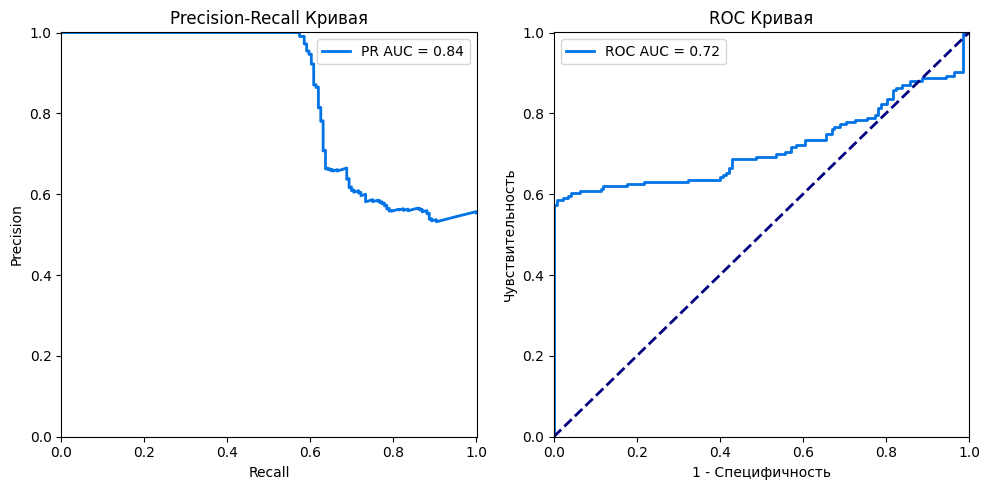

In [243]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

all_probs = []  # Здесь будут храниться вероятности для всех данных
all_labels = []  # Здесь будут храниться истинные метки

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        probs = F.softmax(outputs, dim=1)
        all_probs += [probs[0][1].numpy()]
        all_labels += list(labels.numpy())

# Преобразование в массивы numpy
y_probs = np.array(all_probs)
y_true = np.array(all_labels)

# Расчет Precision-Recall  и AUC-PR
precision, recall, _ = precision_recall_curve(y_true, y_probs)
auc_pr = auc(recall, precision)

# Расчет ROC-кривой и AUC-ROC
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc_roc = auc(fpr, tpr)

# Рассчет чувствительности (True Positive Rate) и специфичности (True Negative Rate)
sensitivity = tpr
specificity = 1 - fpr

# Построение PR-кривой
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='#0073E6', lw=2, label=f'PR AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0,1.0005])
plt.ylim([0,1.0005])
plt.title('Precision-Recall Кривая')
plt.legend(loc='best')

# Построение ROC-кривой
plt.subplot(1, 2, 2)
plt.plot(1- specificity, sensitivity, color='#0073E6', lw=2, label=f'ROC AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('1 - Специфичность')
plt.ylabel('Чувствительность')
plt.title('ROC Кривая')
plt.legend(loc='best')
plt.xlim([0,1.0005])
plt.ylim([0,1.0005])
plt.tight_layout()
plt.show()


In [237]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_new(cm, classes=['здоров','болен'], normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')

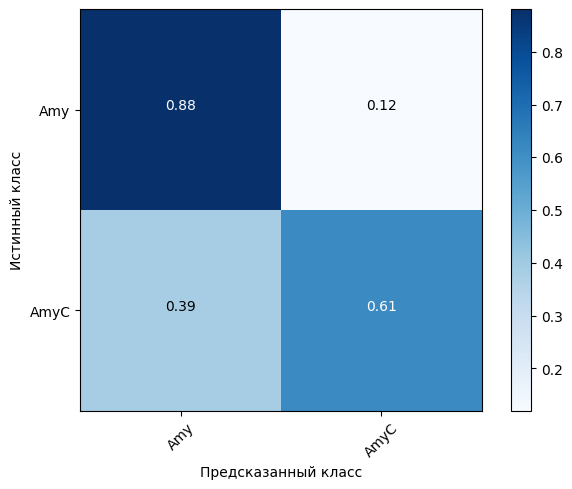

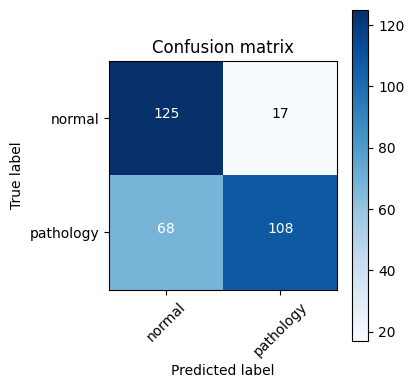

In [240]:
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix_new(cm, classes=['Amy','AmyC'], normalize=True, title='')

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [241]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.65      0.88      0.75       142
           1       0.86      0.61      0.72       176

    accuracy                           0.73       318
   macro avg       0.76      0.75      0.73       318
weighted avg       0.77      0.73      0.73       318

